This notebook contains code for creating a Embeddings NN in order to estimate the ratings that the users gave for certain items. The data used was an Amazon dataset containing ratings of video games.

The code is a sample code from the project conducted for the Machine Learning for Behavioral Data course. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Track 2 - E-Commerce

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
DATA_PATH = "/content/drive/MyDrive/MLBH/data/"

In [ ]:
videoGames_ratings=pd.read_csv(DATA_PATH+"sports.csv",names=['user_id', 'item_id','rating','timestamp'])
videoGames_ratings.head()

,user_id,item_id,rating,timestamp
0,0000031895,A23K73OVXJ04EG,5.0,1391212800
1,0000031895,A2681T699HV6H1,4.0,1384905600
2,0000031895,A374PA18DCGS5Y,1.0,1477008000
3,0000031895,A14PVW2N5YBWSA,5.0,1476748800
4,0000031895,A2KWBC44QI2567,1.0,1476662400


### Data cleaning and exloratory analysis

In [ ]:
print("The dataset has {} records in total".format(len(videoGames_ratings)))
print("The dataset has {} users".format(len(videoGames_ratings['user_id'].unique())))
print("The dataset has {} video games items".format(len(videoGames_ratings['item_id'].unique())))

The dataset has 12980837 records in total
The dataset has 957764 users
The dataset has 6703391 video games items


In [ ]:
videoGames_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980837 entries, 0 to 12980836
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 396.1+ MB


In [ ]:
videoGames_ratings.describe()

,rating,timestamp
count,1.298084e+07,1.298084e+07
mean,4.243398e+00,1.447025e+09
std,1.240891e+00,5.756559e+07
min,1.000000e+00,9.261216e+08
25%,4.000000e+00,1.417910e+09
50%,5.000000e+00,1.456099e+09
75%,5.000000e+00,1.487549e+09
max,5.000000e+00,1.538698e+09


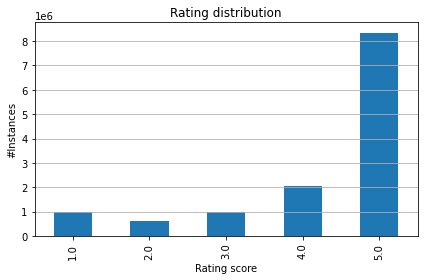

In [ ]:
plt.title('Rating distribution')
ratings_dist = videoGames_ratings.groupby('rating')['rating'].count()
ratings_dist.plot(kind='bar')
plt.xlabel('Rating score')
plt.ylabel('#Instances')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

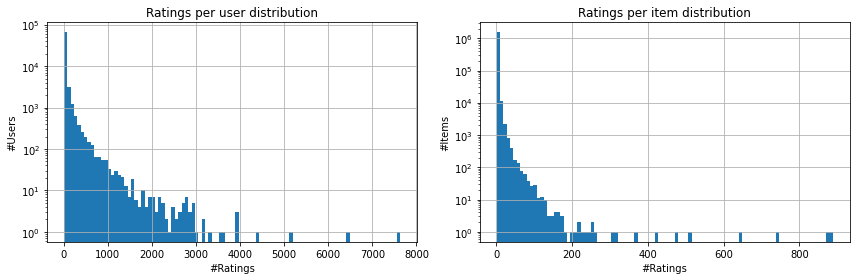

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Ratings per user distribution')
ratings_per_user = videoGames_ratings.groupby('user_id')['rating'].count()
ratings_per_user.hist(bins=100)
plt.yscale('log')
plt.xlabel('#Ratings')
plt.ylabel('#Users')

plt.subplot(1, 2, 2)
plt.title('Ratings per item distribution')
ratings_per_item = videoGames_ratings.groupby('item_id')['rating'].count()
ratings_per_item.hist(bins=100)
plt.yscale('log')
plt.xlabel('#Ratings')
plt.ylabel('#Items')


plt.tight_layout()
plt.show()

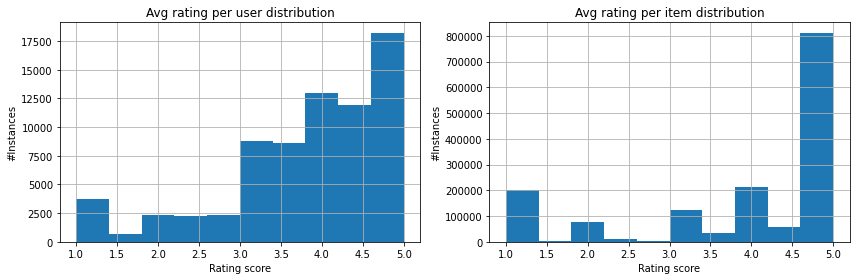

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Avg rating per user distribution')
ratings_per_user = videoGames_ratings.groupby('user_id')['rating'].mean()
ratings_per_user.hist()
plt.xlabel('Rating score')
plt.ylabel('#Instances')

plt.subplot(1, 2, 2)
plt.title('Avg rating per item distribution')
ratings_per_item = videoGames_ratings.groupby('item_id')['rating'].mean()
ratings_per_item.hist()
plt.xlabel('Rating score')
plt.ylabel('#Instances')

plt.tight_layout()
plt.show()

In [ ]:
#removing items that have less than 50 ratings
ratings_per_item = videoGames_ratings.groupby('item_id')['rating'].count()
items_to_remove = ratings_per_item[ratings_per_item < 50]
videoGames_ratings = videoGames_ratings[~videoGames_ratings['item_id'].isin(items_to_remove.index)]

#transforming the user and items ids as indxs from 1 to n_users/n_movies
unique_users = videoGames_ratings.user_id.unique()
user_to_index = {old: new for new, old in enumerate(unique_users)}
new_users = videoGames_ratings.user_id.map(user_to_index)

unique_movies = videoGames_ratings.item_id.unique()
movie_to_index = {old: new for new, old in enumerate(unique_movies)}
new_movies = videoGames_ratings.item_id.map(movie_to_index)

n_users = unique_users.shape[0]
n_movies = unique_movies.shape[0]

videoGames_ratings = pd.DataFrame({'user_id': new_users, 'item_id': new_movies, 'rating':videoGames_ratings['rating']})
X = pd.DataFrame({'user_id': new_users, 'item_id': new_movies})
y = videoGames_ratings['rating'].astype(np.float32)

In [ ]:
X

,user_id,item_id
321,0,0
554,1,1
1172,2,2
1305,2,3
3062,3,4
...,...,...
12980433,63606,125
12980476,63607,1347
12980480,63607,1240
12980687,63608,575


In [ ]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('user_id')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('item_id')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='user_id').
        join(top_movies, rsuffix='_r', how='inner', on='item_id'))

    return pd.crosstab(top.user_id, top.item_id, top.rating, aggfunc=np.mean)

In [ ]:
tabular_preview(videoGames_ratings)

item_id,12,58,59,196,209,335,345,638,803
user_id,,,,,,,,,
1910,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN
4417,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
4619,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN
4760,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0
4974,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
5697,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN
6016,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
7487,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11402,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN


An Embedding NN that takes as inputs the embedings of the users and items and estimates the rating.


In [ ]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.
        n_movies: 
            Number of unique movies in the dataset.
        n_factors: 
            Number of columns in the embeddings matrix.
        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.
        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).
        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02):
        
        super().__init__()

            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(
            nn.Linear(1, 70),
            nn.Dropout(0.2),
            nn.Linear(70, 50),
            nn.Dropout(0.2),
            nn.Linear(50, 20),
            nn.Dropout(0.2),
            nn.Linear(20, 10),
            nn.ReLU(),
        )
        self.fc = nn.Linear(10, 1)
        
    def forward(self, users, movies, minmax=None):
        A = self.u(users)
        B = self.m(movies)
        features = torch.bmm(A.view(A.shape[0], 1, A.shape[1]), B.view(B.shape[0], B.shape[1], 1))
        x = self.drop(features)
        #print(x.shape)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        #for scaling between 1 and 5(min and max rating)
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    


In [ ]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
        Yield num_batches batches of size batch_size from the dataset y,tx
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [ ]:
def train(net, datasets, datasizes ,criterion ,optimizer, BATCH_SIZE, n_epochs):
  patience = 10
  no_improvements = 0
  best_loss = np.inf
  best_weights = None
  history = []
  minmax = (1.0,5.0)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  net.to(device)
  for epoch in range(n_epochs):
      stats = {'epoch': epoch + 1, 'total': n_epochs}
      
      for phase in ('train', 'val'):
          training = phase == 'train'
          running_loss = 0.0
          n_batches = 0
          
          for batch_y, batch_x in batch_iter(datasets[phase][1], datasets[phase][0], BATCH_SIZE,int(dataset_sizes[phase]/BATCH_SIZE),shuffle=training):
              batch_x, batch_y = torch.from_numpy(batch_x).to(device), torch.from_numpy(batch_y).to(device)
              
              optimizer.zero_grad()
          
              # compute gradients only during training phase
              with torch.set_grad_enabled(training):
                  outputs = net(batch_x[:, 0], batch_x[:, 1], minmax)
                  #print(outputs.shape)
                  loss = criterion(outputs.view(-1), batch_y)
                  
                  # update weights and rates when in training phase
                  if training:
                      loss.backward()
                      optimizer.step()
                      
              running_loss += loss.item()
              
          epoch_loss = running_loss / dataset_sizes[phase]
          stats[phase] = epoch_loss
          
          # early stopping
          if phase == 'val':
              if epoch_loss < best_loss:
                  print('loss improvement on epoch: %d' % (epoch + 1))
                  best_loss = epoch_loss
                  best_weights = copy.deepcopy(net.state_dict())
                  no_improvements = 0
              else:
                  no_improvements += 1
                  
      history.append(stats)
      print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
      if no_improvements >= patience:
          print('early stopping after epoch {epoch:03d}'.format(**stats))
          break

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20)

In [ ]:
y_train

11514178    5.0
2601334     3.0
3024123     5.0
501005      5.0
8011668     5.0
           ... 
12609302    5.0
9916314     4.0
2117227     4.0
9961944     5.0
9792272     5.0
Name: rating, Length: 104270, dtype: float32

In [ ]:
n = len(videoGames_ratings['user_id'].unique())
m = len(videoGames_ratings['item_id'].unique())

In [ ]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150,  
    embedding_dropout=0.5)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
lr = 1e-3
wd = 1e-5
BATCH_SIZE = 2000
n_epochs = 100


datasets = {'train': (np.array(X_train), np.array(y_train)), 'val': (np.array(X_valid), np.array(y_valid))}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr)#, weight_decay=wd)

train(net, datasets, dataset_sizes ,criterion ,optimizer, BATCH_SIZE, n_epochs)

loss improvement on epoch: 1
[001/100] train: 2.0627 - val: 3.0075
[002/100] train: 1.9969 - val: 3.0499
loss improvement on epoch: 3
[003/100] train: 1.9919 - val: 2.9619
[004/100] train: 1.9844 - val: 3.0393
[005/100] train: 1.9680 - val: 2.9856
[006/100] train: 1.9378 - val: 3.1380
[007/100] train: 1.8937 - val: 3.0614
[008/100] train: 1.8452 - val: 3.1566
[009/100] train: 1.7926 - val: 3.0097
[010/100] train: 1.7389 - val: 3.1945
[011/100] train: 1.6894 - val: 3.0627
[012/100] train: 1.6379 - val: 3.2859
[013/100] train: 1.5922 - val: 3.1537
early stopping after epoch 013
